# AURORA Dataset Overview 🌊

This notebook provides an initial exploration of the AURORA dataset sample.  
We will:
- Review the directory structure
- Load and preview the multibeam echosounder and CTD data
- Visualize any available navigation coordinates (if present)

Dataset path: `../data/raw/aurora_dataset_sample/`
- ---

This notebook provides an overview and validation of the processed MBES (Multibeam Echosounder) dataset extracted from `.all` files, and optionally aligns it with Side Scan Sonar (SSS) data.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define path
notebook_dir = os.getcwd()
mbes_path = os.path.join(notebook_dir, "mbes_points.csv")

# Load the MBES dataset (already contains seafloor_depth)
mbes_df = pd.read_csv(mbes_path)
mbes_df.columns = mbes_df.columns.str.strip()
mbes_df.head()

,x,y,seafloor_depth
0,-135.668304,1.137649,49.370628
1,-135.324829,1.130402,49.593494
2,-134.201874,1.116690,49.527737
3,-133.047348,1.102464,49.471165
4,-131.341446,1.084093,49.176414


## Understanding MBES-Derived Seafloor Depth

**Objective:** Use depth information directly extracted from MBES `.all` files to represent the bathymetry of the seafloor.

**Data Used:** 
The file `mbes_points.csv` contains the following fields:
- `x`: Across-track distance (meters)
- `y`: Along-track distance (meters)
- `seafloor_depth`: Estimated depth from the MBES beams (in meters)

**Clarification:**  
Unlike earlier assumptions that seafloor depth must be computed via `depth + altitude`, here we are directly using the **depth of the beams** recorded by the multibeam sonar. These values are already referenced to the sensor frame and processed during `.all` file parsing.

### Why no need for `depth + altitude`?

- In this dataset, the MBES `.all` file contains the actual **beam footprint depths** (i.e., the distances from the sonar head to the seabed, properly georeferenced).
- Therefore, the derived `seafloor_depth` already serves as a reliable metric for bathymetric analysis.

**Conclusion:**  
We treat `seafloor_depth` as the primary bathymetric feature for:
- Terrain visualization
- Alignment with SSS data
- Machine learning feature extraction

## Seafloor Depth Summary and Interpretation

The `seafloor_depth` values represent the estimated bathymetric depths, derived from the `.all` files by processing valid multibeam sonar datagrams. These depths provide a high-resolution view of the seafloor topography in the surveyed area.

- **Total Points:** 952,320
- **Mean Depth:** ~48.96 m
- **Standard Deviation:** ~0.78 m
- **Minimum Depth:** 41.78 m
- **25th Percentile (Q1):** 48.75 m
- **Median (Q2):** 49.23 m
- **75th Percentile (Q3):** 49.43 m
- **Maximum Depth:** 60.50 m

### Interpretation

- **Stable Bathymetry:**  
  The relatively low standard deviation across nearly a million points indicates that the surveyed area exhibits a **uniform seafloor**. This suggests a consistent terrain, typical of continental shelf regions or areas with gentle topographic variation.

- **Presence of Deeper Structures:**  
  The maximum value (~60.5 m) is significantly higher than the upper quartile (~49.4 m), suggesting **localized deeper zones**. These may correspond to features such as small valleys, ridges, or depressions.

- **Ready for Analysis:**  
  The cleaned and filtered seafloor data is now ready to be:
  - Correlated with side-scan sonar intensity values.
  - Used as a feature for training machine learning models in habitat classification.
  - Explored through clustering techniques (e.g., DBSCAN, K-Means) for pattern discovery or region segmentation.

These insights support the broader goal of creating a reliable, analysis-ready bathymetric base layer to inform further semantic segmentation tasks on benthic habitats.

In [2]:
mbes_df['seafloor_depth'].describe()

count    952320.000000
mean         48.963311
std           0.781796
min          41.784378
25%          48.750183
50%          49.237337
75%          49.430923
max          60.504559
Name: seafloor_depth, dtype: float64

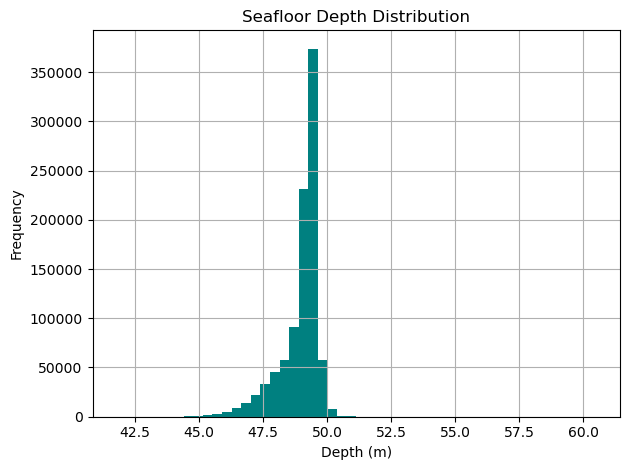

In [3]:
plt.hist(mbes_df['seafloor_depth'], bins=50, color='teal')
plt.title("Seafloor Depth Distribution")
plt.xlabel("Depth (m)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## Point Cloud Visualization

To better understand the spatial distribution of the seafloor, we visualize the `seafloor_depth` as a 2D point cloud using the across-track (`x`) and along-track (`y`) distances obtained from the multibeam echosounder (MBES) datagrams.

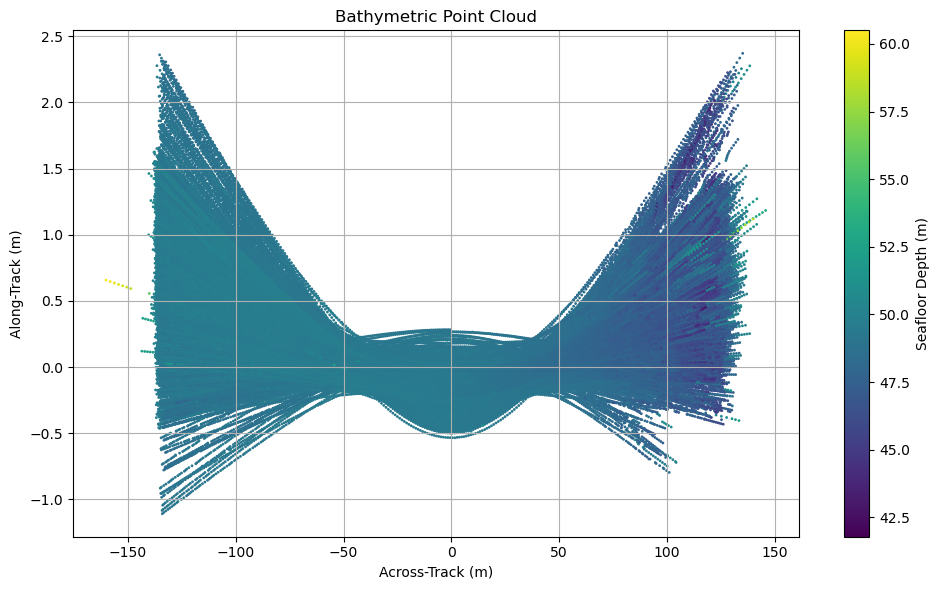

In [4]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(mbes_df['x'], mbes_df['y'], c=mbes_df['seafloor_depth'], cmap='viridis', s=1)
plt.colorbar(sc, label='Seafloor Depth (m)')
plt.xlabel("Across-Track (m)")
plt.ylabel("Along-Track (m)")
plt.title("Bathymetric Point Cloud")
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot Description

- **X-axis:** Across-Track Distance (meters) — left/right offset from the AUV.
- **Y-axis:** Along-Track Distance (meters) — forward movement of the AUV over time.
- **Color (c):** Seafloor depth (`seafloor_depth`), ranging approximately from 42 m to 60 m.
- **Colormap:** `viridis` is used to intuitively represent depth variations (shallower = yellow, deeper = dark blue).

### Key Observations

- The resulting "V" shape reflects typical multibeam sonar swath geometry — wider beam spread at the edges and denser hits at the center.
- Shallower values (in yellow-green) may correspond to bathymetric rises, ridges, or obstacles.
- Deeper zones are concentrated towards the far ends of the swath, possibly due to beam angle geometry or real seafloor topography.

This visual check serves to validate that the depth parsing and filtering were successful and confirms that the processed MBES data is usable for further habitat or terrain modeling.